In [2]:
import numpy as np
import scipy.io
import torch
import os
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
#import netCDF4 as nc
#from prettytable import PrettyTable
#from count_trainable_params import count_parameters    
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.transforms import ScaledTranslation


from nn_FNO import FNO1d
from nn_MLP import MLP_Net
from nn_step_methods import *

2.1.1+cu121
2.1.1+cu121
2.1.1+cu121
2.1.1+cu121


In [21]:
device = 'cuda'
skip_factor = 0 #Number of timesteps to skip (to make the saved data smaller), set to zero to not save a skipped version

time_step = 1e-3
lead = int((1/1e-3)*time_step)
print(lead,'lead')


net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_PEC4step_lead1/chkpt_FNO_PEC4step_lead1_epoch60.pt"
print(net_file_name)
#change this to use a different network

step_func = PEC4_step #this determines the step funciton used in the eval step, has inputs net (pytorch network), input batch, time_step

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KS_1024.pkl', 'rb') as f: #change based on eval data location.
    data = pickle.load(f)
data=np.asarray(data[:,:250000])

trainN=150000 #dont explicitly need this as no training is done in file
input_size = 1024
output_size = 1024

input_test_torch = torch.from_numpy(np.transpose(data[:,trainN:])).float().to(device)
label_test_torch = torch.from_numpy(np.transpose(data[:,trainN+lead::lead])).float().to(device)
label_test = np.transpose(data[:,trainN+lead::lead])
print(label_test_torch.shape)

1 lead
/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_PEC4step_lead1/chkpt_FNO_PEC4step_lead1_epoch60.pt
torch.Size([99999, 1024])


In [22]:
# device = 'cuda'  #change to cpu if no cuda available

#model parameters

input_size = 1024
hidden_layer_size = 2000
output_size = 1024

modes = 256 # number of Fourier modes to multiply
width = 256  # input and output chasnnels to the FNO layer

my_net = FNO1d(modes, width, 1, 1)
# my_net = MLP_Net(input_size, hidden_layer_size, output_size)
my_net.load_state_dict(torch.load(net_file_name, map_location=torch.device(device)))


step_method = step_func(my_net, device, time_step).to(device)

In [23]:
M = label_test_torch.shape[0] - 1
M = 1000
num_init_conds = 1
net_pred = np.zeros([M, np.size(label_test,1)])
net_pred_truth = np.zeros([M, np.size(label_test,1)])
e_vec = np.zeros([M, np.size(label_test,1)])
eps_sum = np.zeros([M, np.size(label_test,1)])


print(M)
print('Model loaded')

# ygrad = torch.zeros([ M, input_size, input_size])
# ygrad_truth = torch.zeros([ M ,input_size, input_size])

# def batch_jacobian_func(input_tens):
#     ygrad = torch.zeros(input_tens.shape[0], input_size, input_size)
#     for num in range(0, input_tens.shape[0]):
#         ygrad[num] = torch.autograd.functional.jacobian(step_method, torch.reshape(input_tens[int(num)],(1, input_size,1))).reshape(1,1024,1024)
#     return ygrad

for k in range(0,M):
    if k % 100 == 0:
        print(k)
    if (k==0):
        net_output = step_method(torch.reshape(label_test_torch[k,:],(num_init_conds, input_size,1)))
        net_pred [k,:] = torch.reshape(net_output,(num_init_conds, input_size)).detach().cpu().numpy()
        net_output_truth = step_method(torch.reshape(label_test_torch[k,:],(num_init_conds, input_size,1)))
        net_pred_truth[k,:] = torch.reshape(net_output_truth,(num_init_conds, input_size)).detach().cpu().numpy()
        e_vec[k] = (net_output_truth.squeeze(2).squeeze(0) - label_test_torch[k+1]).detach().cpu().numpy()

        eps_sum[k] = (net_output_truth.squeeze(-1) - label_test_torch[ k+1]).detach().cpu().numpy()

    else:
        net_output = step_method(torch.reshape(torch.from_numpy(net_pred[k-1,:]),(num_init_conds, input_size,1)).float())
        net_pred [k,:] = torch.reshape(net_output,(num_init_conds, input_size)).detach().cpu().numpy()
        

        net_output_truth, e_vec_temp = torch.func.jvp(step_method, (label_test_torch[k,:].reshape(1,1024,1),), (torch.tensor(e_vec[k-1]).reshape(1,1024,1), ))  
        e_vec[k] = e_vec_temp.squeeze(2).detach().cpu().numpy()
        
        net_pred_truth[k,:] = torch.reshape(net_output_truth,(num_init_conds, input_size)).detach().cpu().numpy()
                
        e_vec[k] += (net_output_truth.squeeze(2).squeeze(0) - label_test_torch[k+1]).detach().cpu().numpy() 

        net_pred_truth[k,:] = torch.reshape(net_output_truth,(num_init_conds, input_size)).detach().cpu().numpy()

        eps_sum[k] = eps_sum[k-1] + (net_output_truth.squeeze(-1) - label_test_torch[ k+1]).detach().cpu().numpy()
print('Finished')


1000
Model loaded
0
100
200
300
400
500
600
700
800
900
Finished


In [24]:
net_pred_no_tendency = net_pred
eps_sum_no_tendency = eps_sum

In [20]:
net_pred_tendency = net_pred
eps_sum_tendency = eps_sum

In [49]:
net_pred_jac = net_pred

In [54]:
net_pred_no_jac = net_pred

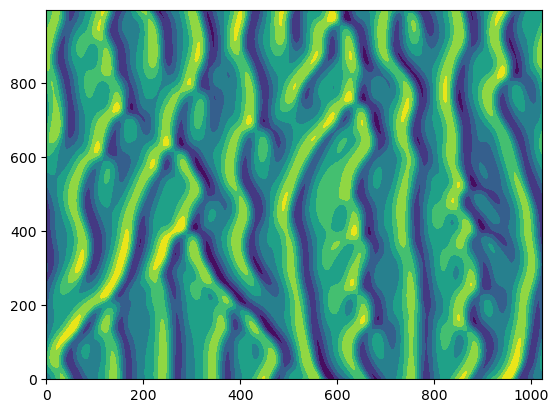

In [6]:
plt.contourf(net_pred_jac, vmin=-3, vmax=3)

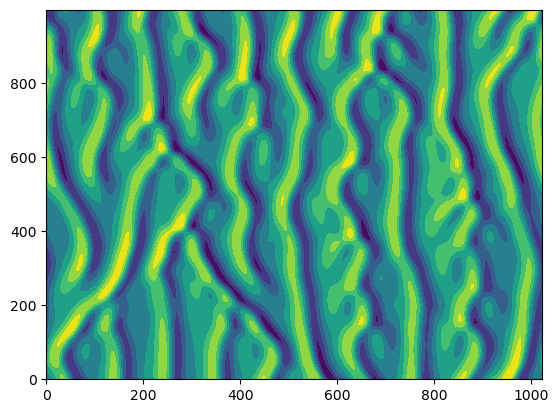

In [26]:
plt.contourf(net_pred_no_jac, vmin=-3, vmax=3)

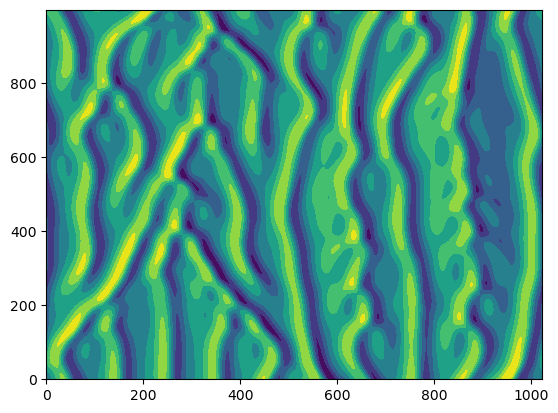

In [28]:
plt.contourf(label_test_torch[:M].cpu(), vmin=-3, vmax=3)

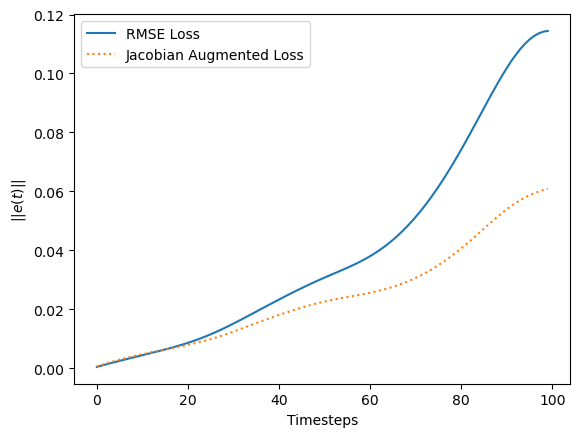

In [58]:
trange = 100
# net_residual = net_pred[:trange] - label_test_torch[1:1+trange].detach().cpu().numpy()
# net_residual = net_residual / torch.norm(net_residual, dim=1).unsqueeze(1)

# plt.plot(np.linalg.norm(net_residual, axis=1))
# plt.plot(np.linalg.norm(e_vec[:trange], axis=1), ':')


plt.plot(np.sqrt(np.mean((net_pred_no_jac[0:trange] - label_test[101:trange+101])**2, axis=1) ))
plt.plot(np.sqrt(np.mean((net_pred_jac[0:trange] - label_test[101:trange+101])**2, axis=1) ), ':')

# plt.plot(np.sqrt(np.mean((net_pred[0:trange] - label_test[1:trange+1])**2, axis=1) ) - np.sqrt(np.mean((net_pred_jac[0:trange] - label_test[1:trange+1])**2, axis=1) ))

# plt.plot(np.linalg.norm(e_vec[:trange], axis=1), ':')

# plt.plot(np.linalg.norm(net_residual, axis=1) - np.linalg.norm(e_vec[:trange], axis=1))
plt.xlabel('Timesteps')
plt.ylabel(r'$||e(t)||$')
# plt.title('Norm of the diffrence between true residual vector and approximation')
plt.legend(['RMSE Loss','Jacobian Augmented Loss'])
# plt.savefig('RMSE_loss_comparison.png', bbox_inches='tight')

In [252]:
def Dataloader(data,batch_size,batch_time, key):
    time_chunks = []
    for i in range(data.shape[0] - batch_time*lead):
        time_chunks.append(data[i:i+batch_time*lead:lead])
    extra = len(time_chunks) % batch_size
    if extra==0:
        time_chunks = np.array(time_chunks)
    else:
        time_chunks = np.array(time_chunks[:-extra])
    rng = np.random.default_rng(key)
    time_chunks = rng.permutation(time_chunks)
    split = np.array(np.split(time_chunks,time_chunks.shape[0]//batch_size))
    return split


device = 'cuda'
skip_factor = 0 #Number of timesteps to skip (to make the saved data smaller), set to zero to not save a skipped version

time_step = 1e-3
lead = int((1/1e-3)*time_step)
print(lead,'lead')

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KS_1024.pkl', 'rb') as f: #change based on eval data location.
    data = pickle.load(f)
data=np.asarray(data[:,:250000])

trainN=150000 #dont explicitly need this as no training is done in file
input_size = 1024
output_size = 1024

input_test_torch = torch.from_numpy(np.transpose(data[:,trainN:])).to(device)
# label_test_torch = torch.from_numpy(np.transpose(data[:,trainN+lead::])).float().to(device)
# label_test = np.transpose(data[:,trainN+lead::lead])

num_init_conds = 10
M_full = 10000

# rng = np.random.default_rng()
# key = rng.integers(100, size=num_init_conds)
# label_multi_full = torch.Tensor(Dataloader(input_test_torch.detach().cpu().numpy(), batch_size=num_init_conds, batch_time = M_full, key=key)) #n_batch x batch_size x time x channels x w x h
# label_multi = label_multi_full[0].to(device)


inds = torch.randint(input_test_torch.shape[0] - M_full*lead, size=(num_init_conds,))
print('before load')
label_multi_full = torch.zeros([0, M_full, 1024]).to(device)
for ind in inds:
    label_multi_full = torch.cat([label_multi_full, input_test_torch[ind:ind+M_full*lead:lead].unsqueeze(0)], dim=0)
print('After load')

1 lead
before load
After load


In [274]:
time_step = 1e-1
lead = int((1/1e-3)*time_step)
print(lead,'lead')
M = int(M_full/lead)

# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_PEC4step_lead1/chkpt_FNO_PEC4step_lead1_epoch60.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Eulerstep_lead100_train_multistep_jacobian_proj/chkpt_FNO_Eulerstep_lead100_train_multistep_jacobian_proj.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Eulerstep_lead100_train_multistep_v3/chkpt_FNO_Eulerstep_lead100_train_multistep_v3.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Eulerstep_lead100_train_multistep_no_pullback/chkpt_FNO_Eulerstep_lead100_train_multistep_no_pullback.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Eulerstep_lead100_train_multistep_hessian/chkpt_FNO_Eulerstep_lead100_train_multistep_hessian.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Eulerstep_lead10_train_multistep_jacobian_basic/chkpt_FNO_Eulerstep_lead10_train_multistep_jacobian_basic.pt"
net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Eulerstep_lead100_train_multistep/chkpt_FNO_Eulerstep_lead100_train_multistep.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Third_order_3rd_udot_w_input_lead10_train_multistep_w_pullback_w_double/chkpt_FNO_Third_order_3rd_udot_w_input_lead10_train_multistep_w_pullback_w_double_epoch_100.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Second_order_w_dt_step_w_input_lead1_train_multistep_w_pullback/chkpt_FNO_Second_order_w_dt_step_w_input_lead1_train_multistep_w_pullback.pt"
# net_file_name = "/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Directstep_lead100_train_multistep/chkpt_FNO_Directstep_lead100_train_multistep.pt"

print(net_file_name)
#change this to use a different network

step_func = Euler_step #this determines the step funciton used in the eval step, has inputs net (pytorch network), input batch, time_step

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KS_1024.pkl', 'rb') as f: #change based on eval data location.
    data = pickle.load(f)
data=np.asarray(data[:,:250000])

trainN=150000 #dont explicitly need this as no training is done in file
input_size = 1024
output_size = 1024

input_test_torch = torch.from_numpy(np.transpose(data[:,trainN:])).float().to(device)
label_test_torch = torch.from_numpy(np.transpose(data[:,trainN+lead::lead])).float().to(device)
label_test = np.transpose(data[:,trainN+lead::lead])
print(label_test_torch.shape)

#model parameters
input_size = 1024
hidden_layer_size = 2000
output_size = 1024

modes = 256 # number of Fourier modes to multiply
width = 256  # input and output chasnnels to the FNO layer

my_net = FNO1d(modes, width, 1, 1)
# my_net = MLP_Net(input_size, hidden_layer_size, output_size)
# my_net.load_state_dict(torch.load(net_file_name, map_location=torch.device(device)))

step_method = step_func(my_net, device, time_step).to(device)

my_net.load_state_dict(torch.load(net_file_name, map_location=torch.device(device)))


100 lead
/glade/derecho/scratch/cainslie/conrad_net_stability/model_chkpts/FNO_Eulerstep_lead100_train_multistep/chkpt_FNO_Eulerstep_lead100_train_multistep.pt
torch.Size([999, 1024])


<All keys matched successfully>

In [275]:
# M=2

net_pred_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
net_pred_truth_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
e_vec_multi_pre_eps = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
e_vec_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
eps_sum_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])

# ygrad = torch.zeros([num_init_conds, M-1, input_size, input_size])
# ygrad_truth = torch.zeros([num_init_conds, M ,input_size, input_size])


def batch_jacobian_func(input_tens):
    ygrad = torch.zeros(input_tens.shape[0], input_size, input_size)
    for num in range(0, input_tens.shape[0]):
        ygrad[num] = torch.autograd.functional.jacobian(step_method, torch.reshape(input_tens[int(num)],(1, input_size,1))).reshape(1,1024,1024)
    # ygrad = torch.func.vmap(torch.func.jacrev(step_method))(input_tens.reshape([input_tens.shape[0], input_size, 1]))
    return ygrad


label_multi = label_multi_full[:,::lead].float()

step_method.eval()
print('Starting '+str(M))
for k in range(0, M-1):
    if k % 1000 == 0:
        print(k)
    if (k==0):

        net_output = step_method(torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1)))
        net_pred_multi [:, k,:] = torch.reshape(net_output,(num_init_conds, input_size)).detach().cpu().numpy()
        
        net_output_truth = step_method(torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1)))
        net_pred_truth_multi[:, k,:] = torch.reshape(net_output_truth,(num_init_conds, input_size)).detach().cpu().numpy()

        e_vec_multi_pre_eps[:, k] = 0 
        e_vec_multi[:, k] = (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()
        
        eps_sum_multi[: ,k] = (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()

    
        # ygrad[:, k] = batch_jacobian_func(label_multi[:,0,:].cuda())
        # ygrad_truth[:,k] = batch_jacobian_func(label_multi[:,0,:].cuda())
        
    else:

        net_output = step_method(torch.reshape(torch.from_numpy(net_pred_multi[:, k-1,:]),(num_init_conds, input_size,1)).float().cuda())
        net_pred_multi [:, k,:] = torch.reshape(net_output,(num_init_conds, input_size)).detach().cpu().numpy()

        net_output_truth, e_vec_temp = torch.func.jvp(step_method, (label_multi[:, k].reshape([num_init_conds, input_size, 1]),), (torch.tensor(e_vec_multi[:, k-1]).reshape([num_init_conds, input_size,1 ]), ))  
        net_pred_truth_multi[:, k,:] = torch.reshape(net_output_truth,(num_init_conds, input_size)).detach().cpu().numpy()


        e_vec_multi_pre_eps[:, k] = e_vec_temp.squeeze(2).detach().cpu().numpy()
        e_vec_multi[:, k] += e_vec_temp.squeeze(2).detach().cpu().numpy() + (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy() 

        
        eps_sum_multi[:,k] = eps_sum_multi[:, k-1] + (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()
        
        # ygrad[:, k] = batch_jacobian_func(torch.tensor(net_pred_multi[:, k-1,:]).float().cuda())
        # ygrad_truth[:,k] = batch_jacobian_func(label_multi[:, k, :].cuda())


print('Finished')

Starting 100
0
Finished


In [261]:
net_pred_lead1 = net_pred_multi
net_pred_truth_lead1 = net_pred_truth_multi
e_vec_multi_pre_eps_lead1 = e_vec_multi_pre_eps
e_vec_multi_lead1 = e_vec_multi
eps_sum_multi_lead1 = eps_sum_multi

lable_lead1 = label_multi

In [170]:
ygrad_lead1 = ygrad

In [262]:
net_pred_lead10 = net_pred_multi
net_pred_truth_lead10 = net_pred_truth_multi
e_vec_multi_pre_eps_lead10 = e_vec_multi_pre_eps
e_vec_multi_lead10 = e_vec_multi
eps_sum_multi_lead10 = eps_sum_multi

lable_lead10 = label_multi

In [24]:
ygrad_lead10 = ygrad

In [265]:
net_pred_lead100 = net_pred_multi
net_pred_truth_lead100 = net_pred_truth_multi
e_vec_multi_pre_eps_lead100 = e_vec_multi_pre_eps
e_vec_multi_lead100 = e_vec_multi
eps_sum_multi_lead100 = eps_sum_multi

# ygrad_jac = ygrad_truth
lable_lead100 = label_multi

In [73]:
ygrad_lead100 = ygrad

In [9]:
net_pred_lead1_jac = net_pred_multi
net_pred_truth_lead1_jac = net_pred_truth_multi
e_vec_multi_pre_eps_lead1_jac = e_vec_multi_pre_eps
e_vec_multi_lead1_jac = e_vec_multi
eps_sum_multi_lead1_jac = eps_sum_multi

# ygrad_jac = ygrad_truth
lable_lead1_jac = label_multi

In [50]:
ygrad_lead1_jac = ygrad

In [273]:
net_pred_lead10_jac = net_pred_multi
net_pred_truth_lead10_jac = net_pred_truth_multi
e_vec_multi_pre_eps_lead10_jac = e_vec_multi_pre_eps
e_vec_multi_lead10_jac = e_vec_multi
eps_sum_multi_lead10_jac = eps_sum_multi

# ygrad_jac = ygrad_truth
lable_lead10_jac = label_multi

In [20]:
ygrad_lead10_jac = ygrad

In [276]:
net_pred_lead100_jac = net_pred_multi
net_pred_truth_lead100_jac = net_pred_truth_multi
e_vec_multi_pre_eps_lead100_jac = e_vec_multi_pre_eps
e_vec_multi_lead100_jac = e_vec_multi
eps_sum_multi_lead100_jac = eps_sum_multi

# ygrad_jac = ygrad_truth
lable_lead100_jac = label_multi

In [26]:
ygrad_lead100_jac = ygrad

In [53]:
net_pred_no_jac_multi = net_pred_multi
# y_grad_no_jac = ygrad_truth
lable_multi_no_jac = label_multi

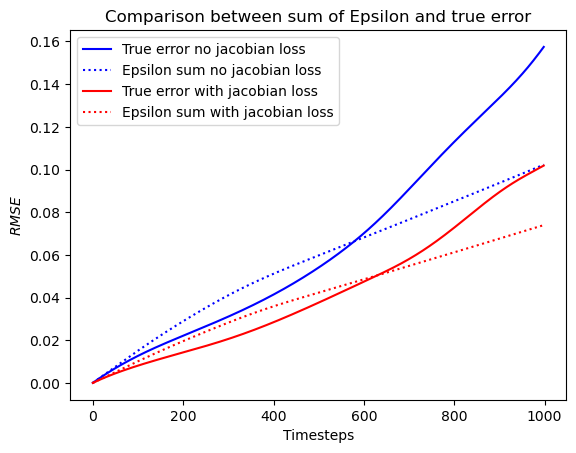

In [125]:
trange = M-1
plt.plot(np.sqrt(np.mean((net_pred_lead10[:, 0:trange] - lable_lead10[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), color='blue', label='True error no jacobian loss')
plt.plot(np.sqrt(np.mean(eps_sum_multi_lead10[:,0:trange]**2, axis=2)).mean(0),':', color='blue', label='Epsilon sum no jacobian loss')

plt.plot(np.sqrt(np.mean((net_pred_lead10_jac[:, 0:trange] - lable_lead10_jac[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), color='red', label='True error with jacobian loss')
plt.plot(np.sqrt(np.mean(eps_sum_multi_lead10_jac[:,0:trange]**2, axis=2)).mean(0),':', color='red', label='Epsilon sum with jacobian loss')


plt.xlabel('Timesteps')
plt.ylabel(r'$RMSE$')
plt.title('Comparison between sum of Epsilon and true error')
plt.legend()
# plt.savefig('RMSE_vs_Epsilon_sum_comparison_lead10.png', bbox_inches='tight') 

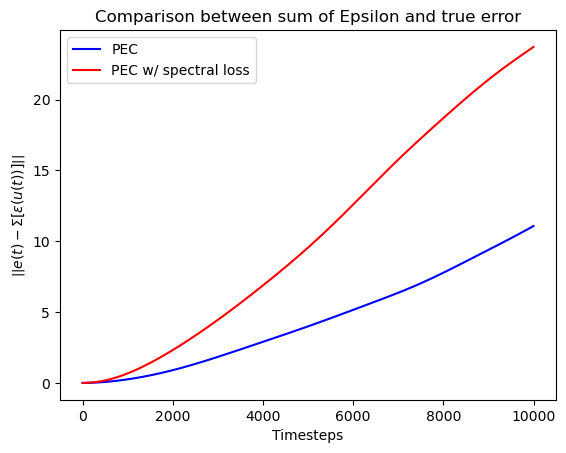

In [68]:
trange = 10000
# rmse = np.sqrt(np.mean((net_pred_lead1[:, 0:trange] - lable_lead1[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0)
# eps_sum = np.sqrt(np.mean(eps_sum_multi_lead1[:,0:trange]**2, axis=2)).mean(0)
# rmse_jac = np.sqrt(np.mean((net_pred_lead1_jac[:, 0:trange] - lable_lead1_jac[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0)
# eps_sum_jac =  np.sqrt(np.mean(eps_sum_multi_lead1_jac[:,0:trange]**2, axis=2)).mean(0)

e_vec = (net_pred_lead1[:, 0:trange] - lable_lead1[:, 1:trange+1].detach().cpu().numpy())
eps_sum = eps_sum_multi_lead1[:,0:trange]
e_vec_jac = (net_pred_lead1_jac[:, 0:trange] - lable_lead1_jac[:, 1:trange+1].detach().cpu().numpy())
eps_sum_jac =  eps_sum_multi_lead1_jac[:,0:trange]

diff_vec_norm = np.linalg.norm(eps_sum - e_vec, axis=2)
diff_vec_norm_jac = np.linalg.norm(eps_sum_jac - e_vec_jac, axis=2)


plt.plot((diff_vec_norm).mean(0), color='blue', label='PEC')

plt.plot((diff_vec_norm_jac).mean(0), color='red', label='PEC w/ spectral loss')

e_vec_norm = np.linalg.norm(e_vec, axis=2)
e_vec_norm_jac = np.linalg.norm(e_vec_jac, axis=2)

tstart = 50

# plt.plot((e_vec_norm[:,tstart:]/e_vec_norm[:,tstart-1:-1]).mean(0), color='blue', label='PEC ')

# plt.plot((e_vec_norm_jac[:,tstart:]/e_vec_norm_jac[:,tstart-1:-1]).mean(0), color='red', label='PEC w/ spectral loss')


plt.xlabel('Timesteps')
plt.ylabel(r'$\left|\left|e(t) - \Sigma[\epsilon(u(t))]\right|\right|$')
plt.title('Comparison between sum of Epsilon and true error')
plt.legend()
# plt.xscale('log')

# plt.savefig('RMSE_diff_Epsilon_sum_comparison_lead1.png', bbox_inches='tight') 

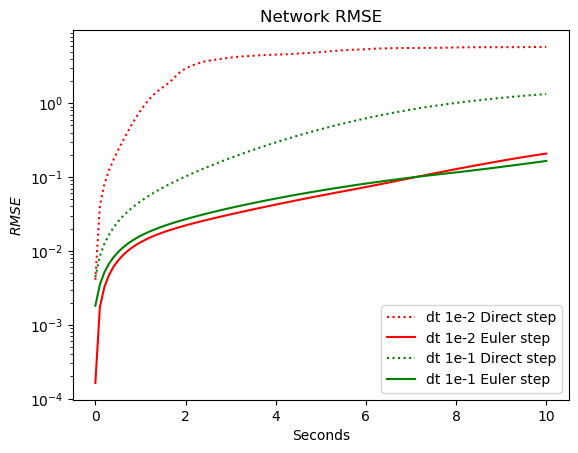

In [279]:
trange = 999

# net_pred_lead1_multi_rmse = np.sqrt(np.mean((net_pred_lead1[:, 0:trange*100:100] - lable_lead1[:, 1:trange*100+1:100].detach().cpu().numpy())**2, axis=2))
# net_pred_lead1_jac_multi_rmse = np.sqrt(np.mean((net_pred_lead1_jac[:, 0:trange*100:100] - lable_lead1_jac[:, 1:trange*100+1:100].detach().cpu().numpy())**2, axis=2))

# plt.semilogy(np.linspace(0, 10, net_pred_lead1_multi_rmse.mean(0).shape[0]), net_pred_lead1_multi_rmse.mean(0), ':', color='blue', label='dt 1e-3 Direct step')
# # plt.fill_between(np.linspace(0, 10, net_pred_lead1_multi_rmse.mean(0).shape[0]), net_pred_lead1_multi_rmse.mean(0) + net_pred_lead1_multi_rmse.std(0),  net_pred_lead1_multi_rmse.mean(0) - net_pred_lead1_multi_rmse.std(0), color='blue', alpha=0.5) 

# plt.semilogy(np.linspace(0, 10, net_pred_lead1_jac_multi_rmse.mean(0).shape[0]), net_pred_lead1_jac_multi_rmse.mean(0), color='blue', label='dt 1e-3 Euler step')
# # plt.fill_between(np.linspace(0, 10, net_pred_lead1_jac_multi_rmse.mean(0).shape[0]), net_pred_lead1_jac_multi_rmse.mean(0) + net_pred_lead1_jac_multi_rmse.std(0),  net_pred_lead1_jac_multi_rmse.mean(0) - net_pred_lead1_jac_multi_rmse.std(0), color='blue', alpha=0.5)


net_pred_lead10_multi_rmse = np.sqrt(np.mean((net_pred_lead10[:, 0:trange*10:10] - lable_lead10[:, 1:trange*10+1:10].detach().cpu().numpy())**2, axis=2))
net_pred_lead10_jac_multi_rmse = np.sqrt(np.mean((net_pred_lead10_jac[:, 0:trange*10:10] - lable_lead10_jac[:, 1:trange*10+1:10].detach().cpu().numpy())**2, axis=2))

plt.semilogy(np.linspace(0, 10, net_pred_lead10_multi_rmse.mean(0).shape[0]), net_pred_lead10_multi_rmse.mean(0), ':', color='red', label='dt 1e-2 Direct step')
# plt.fill_between(np.linspace(0, 10, net_pred_lead10_multi_rmse.mean(0).shape[0]), net_pred_lead10_multi_rmse.mean(0) + net_pred_lead10_multi_rmse.std(0),  net_pred_lead10_multi_rmse.mean(0) - net_pred_lead10_multi_rmse.std(0), color='red', alpha=0.5) 

plt.semilogy(np.linspace(0, 10, net_pred_lead10_jac_multi_rmse.mean(0).shape[0]), net_pred_lead10_jac_multi_rmse.mean(0), color='red', label='dt 1e-2 Euler step')
# plt.fill_between(np.linspace(0, 10, net_pred_lead10_jac_multi_rmse.mean(0).shape[0]), net_pred_lead10_jac_multi_rmse.mean(0) + net_pred_lead10_jac_multi_rmse.std(0),  net_pred_lead10_jac_multi_rmse.mean(0) - net_pred_lead10_jac_multi_rmse.std(0), color='red', alpha=0.5)


net_pred_lead100_multi_rmse = np.sqrt(np.mean((net_pred_lead100[:, 0:trange] - lable_lead100[:, 1:trange+1].detach().cpu().numpy())**2, axis=2))
net_pred_lead100_jac_multi_rmse = np.sqrt(np.mean((net_pred_lead100_jac[:, 0:trange] - lable_lead100_jac[:, 1:trange+1].detach().cpu().numpy())**2, axis=2))

plt.semilogy(np.linspace(0, 10, net_pred_lead100_multi_rmse.mean(0).shape[0]), net_pred_lead100_multi_rmse.mean(0), ':', color='green', label='dt 1e-1 Direct step')
# plt.fill_between(np.linspace(0, 10, net_pred_lead100_multi_rmse.mean(0).shape[0]), net_pred_lead100_multi_rmse.mean(0) + net_pred_lead100_multi_rmse.std(0),  net_pred_lead100_multi_rmse.mean(0) - net_pred_lead100_multi_rmse.std(0), color='green', alpha=0.5) 

plt.semilogy(np.linspace(0, 10, net_pred_lead100_jac_multi_rmse.mean(0).shape[0]), net_pred_lead100_jac_multi_rmse.mean(0), color='green', label='dt 1e-1 Euler step')
# plt.fill_between(np.linspace(0, 10, net_pred_lead100_jac_multi_rmse.mean(0).shape[0]), net_pred_lead100_jac_multi_rmse.mean(0) + net_pred_lead100_jac_multi_rmse.std(0),  net_pred_lead100_jac_multi_rmse.mean(0) - net_pred_lead100_jac_multi_rmse.std(0), color='green', alpha=0.5)


plt.xlabel('Seconds')
plt.ylabel(r'$RMSE$')
plt.title('Network RMSE')
plt.legend()
# plt.savefig('RMSE_step_method_comparison_many_dts_short_rollout.png', bbox_inches='tight')

In [57]:
e_vals_no_jacs = torch.linalg.eigvals(((ygrad_lead1[:,:]-torch.eye(1024))/time_step).to(device))

In [58]:
e_vals_jacs = torch.linalg.eigvals(((ygrad_lead1_jac[:,:]-torch.eye(1024))/time_step).to(device))

In [141]:
e_vals_lead10 = torch.linalg.eigvals(ygrad_lead10[:,:].to(device))
e_vals_lead10_jac = torch.linalg.eigvals(ygrad_lead10_jac[:,:].to(device))

In [97]:
temp_tens = ygrad_lead10[:,0]
for i in np.arange(1,10):
    temp_tens = np.matmul(ygrad_lead10[:,i], temp_tens)
temp_tens_evals = torch.linalg.eigvals(temp_tens.to(device))

In [98]:
temp_tens_2 = ygrad_lead10_jac[:,0]
for i in np.arange(1,10):
    temp_tens_2 = np.matmul(ygrad_lead10[:,i], temp_tens_2)
temp_tens_2_evals = torch.linalg.eigvals(temp_tens_2.to(device))

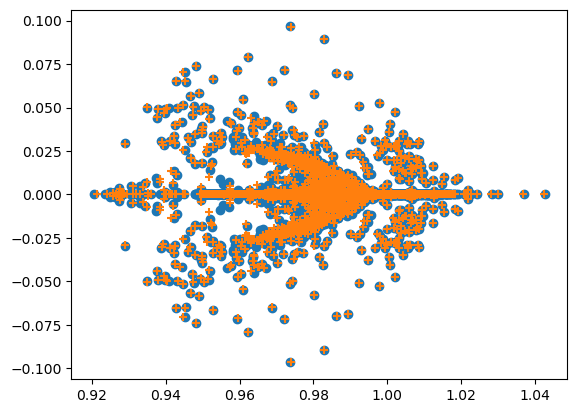

In [111]:
plt.scatter(temp_tens_evals[:,:].flatten().cpu().real, temp_tens_evals[:,:].flatten().cpu().imag)
# plt.scatter(e_vals_lead100[:,:].flatten().cpu().real, e_vals_lead100[:,:].flatten().cpu().imag)
plt.scatter(temp_tens_2_evals[:,:].flatten().cpu().real, temp_tens_2_evals[:,:].flatten().cpu().imag, marker='+')


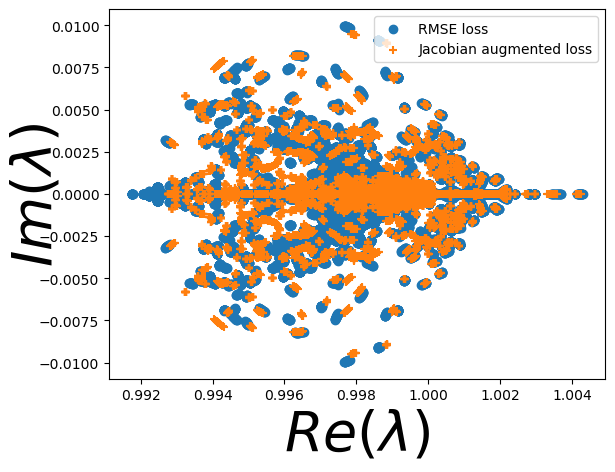

In [151]:
plt.scatter(e_vals_lead10[:,:].flatten().cpu().real, e_vals_lead10[:,:].flatten().cpu().imag)
plt.scatter(e_vals_lead10_jac[:,:].flatten().cpu().real, e_vals_lead10_jac[:,:].flatten().cpu().imag, marker='+')

plt.xlabel(r'$Re(\lambda)$', fontsize=40)
plt.ylabel(r'$Im(\lambda)$', labelpad=-18, fontsize=40)
plt.legend(['RMSE loss', 'Jacobian augmented loss'])

# plt.savefig('E_val_scatter_step_method_comparison_lead10.png', bbox_inches='tight')

Text(0.5, 0.98, 'PDF of real part of network jacobian eigenvalue distribution')

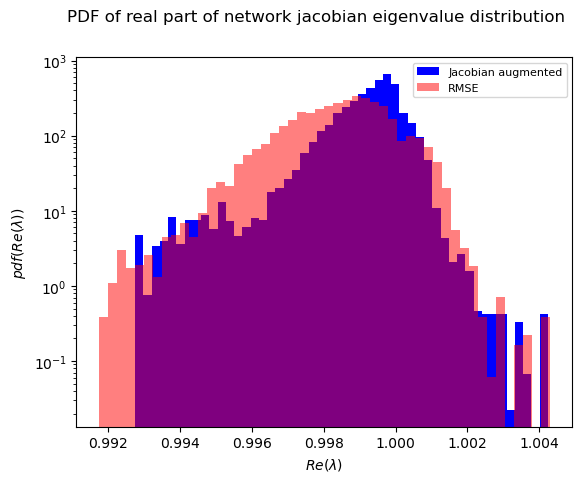

In [146]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.hist(torch.abs(e_vals_lead10_jac).flatten().cpu(), color='blue', bins=50, density=True, log=True)
plt.hist(torch.abs(e_vals_lead10).flatten().cpu(), bins=50, alpha=0.5, density=True, color='red', log=True)

plt.ylabel(r'$pdf(Re(\lambda))$')
plt.xlabel(r'$Re(\lambda)$')
plt.legend(['Jacobian augmented', 'RMSE'], fontsize=8)

# axs[1].hist(torch.imag(e_vals_jacs[:-1,:-1]).flatten().cpu(), color='blue', bins=50, density=True, log=True)
# axs[1].hist(torch.imag(e_vals_no_jacs[:-1,:-1]).flatten().cpu(), bins=50, alpha=0.5, density=True, color='red', log=True)
# axs[1].set_ylabel(r'$pdf(Im(\lambda))$')
# axs[1].set_xlabel(r'$Im(\lambda)$')
# axs[1].legend(['Jacobian augmented loss', 'RMSE loss'], fontsize=8)

plt.suptitle('PDF of real part of network jacobian eigenvalue distribution')

# plt.savefig('E_val_pdf_step_method_comparison_lead100.png', bbox_inches='tight')

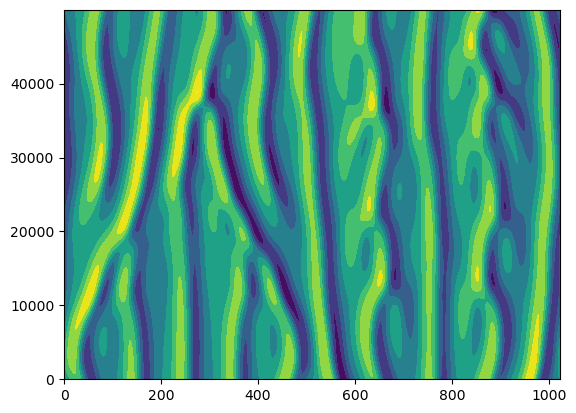

In [90]:
plt.contourf(net_pred_lead1_jac[1], vmin=-3, vmax=3)

In [28]:
lead=100
input_test_torch_temp = input_test_torch[::lead]
basic_var = input_test_torch_temp.var()
diff_var =  (input_test_torch_temp[1:] - input_test_torch_temp[:-1]).var()
diff_2_var =  (input_test_torch_temp[2:] - 2*input_test_torch_temp[1:-1] + input_test_torch_temp[:-2]).var()
basic_var, diff_var, diff_2_var

(tensor(1.5771, device='cuda:0'),
 tensor(0.0010, device='cuda:0'),
 tensor(3.2507e-06, device='cuda:0'))

In [177]:
net_pred_multi[:, :3,:].shape

(10, 3, 1024)

In [231]:
# M=2

net_pred_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
net_pred_truth_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
e_vec_multi_pre_eps = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
e_vec_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])
eps_sum_multi = np.zeros([num_init_conds, M-1, np.size(label_test,1)])

# ygrad = torch.zeros([num_init_conds, M-1, input_size, input_size])
# ygrad_truth = torch.zeros([num_init_conds, M ,input_size, input_size])


def batch_jacobian_func(input_tens):
    ygrad = torch.zeros(input_tens.shape[0], input_size, input_size)
    for num in range(0, input_tens.shape[0]):
        ygrad[num] = torch.autograd.functional.jacobian(step_method, torch.reshape(input_tens[int(num)],(1, input_size,1))).reshape(1,1024,1024)
    # ygrad = torch.func.vmap(torch.func.jacrev(step_method))(input_tens.reshape([input_tens.shape[0], input_size, 1]))
    return ygrad

label_multi = label_multi_full[:,::lead]

step_method.eval()
print('Starting '+str(M))

net_pred_multi[:, :4, :] = label_multi[:,1:5].detach().cpu().numpy()
for k in range(4, M-4):
    if k % 1000 == 0:
        print(k)
    if (k==0):

        net_output = step_method(torch.reshape(label_multi[:,k,:].cuda(),(num_init_conds,4, input_size,1)))
        net_pred_multi [:, k,:] = torch.reshape(net_output,(num_init_conds,4, input_size)).detach().cpu().numpy()
        
        net_output_truth = step_method(torch.reshape(label_multi[:,k,:].cuda(),(num_init_conds,4, input_size,1)))
        net_pred_truth_multi[:, k,:] = torch.reshape(net_output_truth,(num_init_conds,4, input_size)).detach().cpu().numpy()

        # e_vec_multi_pre_eps[:, k] = 0 
        # e_vec_multi[:, k] = (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()
        
        # eps_sum_multi[: ,k] = (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()

    
        # ygrad[:, k] = batch_jacobian_func(label_multi[:,0,:].cuda())
        # ygrad_truth[:,k] = batch_jacobian_func(label_multi[:,0,:].cuda())
        
    else:
        net_output = step_method(torch.from_numpy(net_pred_multi[:, k-4:k,:]).unsqueeze(-1).cuda())
        net_pred_multi [:, k,:] = net_output.squeeze(-1).detach().cpu().numpy()

        # net_output_truth, e_vec_temp = torch.func.jvp(step_method, (label_multi[:, k-3:k+1].unsqueeze(-1),), (torch.tensor(e_vec_multi[:, k-4:k,:]).unsqueeze(-1), ))  
        # net_pred_truth_multi[:, k,:] = net_output_truth.squeeze(-1).detach().cpu().numpy()


        # e_vec_multi_pre_eps[:, k] = e_vec_temp.squeeze(2).detach().cpu().numpy()
        # e_vec_multi[:, k] += e_vec_temp.squeeze(2).detach().cpu().numpy() + (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy() 

        
        # eps_sum_multi[:, k] = eps_sum_multi[:, k-1] + (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()
        
        # ygrad[:, k] = batch_jacobian_func(torch.tensor(net_pred_multi[:, k-1,:]).cuda())
        # ygrad_truth[:,k] = batch_jacobian_func(label_multi[:, k, :].cuda())


print('Finished')

Starting 1000
Finished


In [232]:
net_pred_3rd_ord = net_pred_multi
net_pred_truth_3rd_ord = net_pred_truth_multi
e_vec_multi_pre_eps_3rd_ord = e_vec_multi_pre_eps
e_vec_multi_3rd_ord = e_vec_multi
eps_sum_multi_3rd_ord = eps_sum_multi

lable_3rd_ord = label_multi

In [250]:
k=4

torch.norm(step_method(torch.from_numpy(net_pred_multi[:, k-4:k,:]).unsqueeze(-1).cuda()).squeeze(-1)  - label_multi[:,k+1, :] , dim=-1).mean(0)

tensor(1.6041e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)

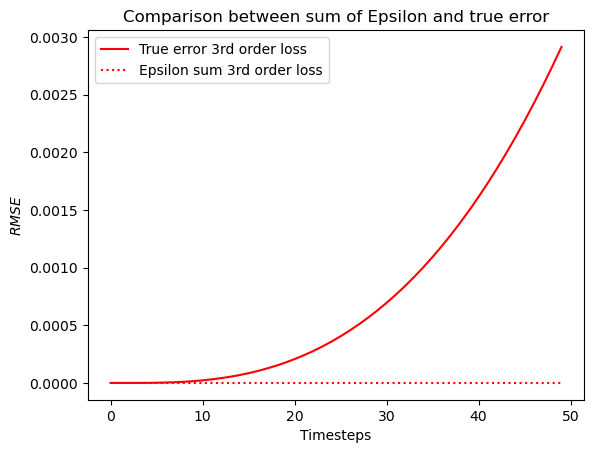

In [251]:
trange = 50
# plt.plot(np.sqrt(np.mean((net_pred_lead10[:, 0:trange] - lable_lead10[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), color='blue', label='True error basic loss')
# plt.plot(np.sqrt(np.mean(eps_sum_multi_lead10[:,0:trange]**2, axis=2)).mean(0),':', color='blue', label='Epsilon sum rmse loss')

plt.plot(np.sqrt(np.mean((net_pred_3rd_ord[:, 0:trange] - lable_3rd_ord[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), color='red', label='True error 3rd order loss')
plt.plot(np.sqrt(np.mean(eps_sum_multi_3rd_ord[:,0:trange]**2, axis=2)).mean(0),':', color='red', label='Epsilon sum 3rd order loss')


plt.xlabel('Timesteps')
plt.ylabel(r'$RMSE$')
plt.title('Comparison between sum of Epsilon and true error')
plt.legend()
# plt.savefig('RMSE_vs_Epsilon_sum_comparison_lead10.png', bbox_inches='tight') 

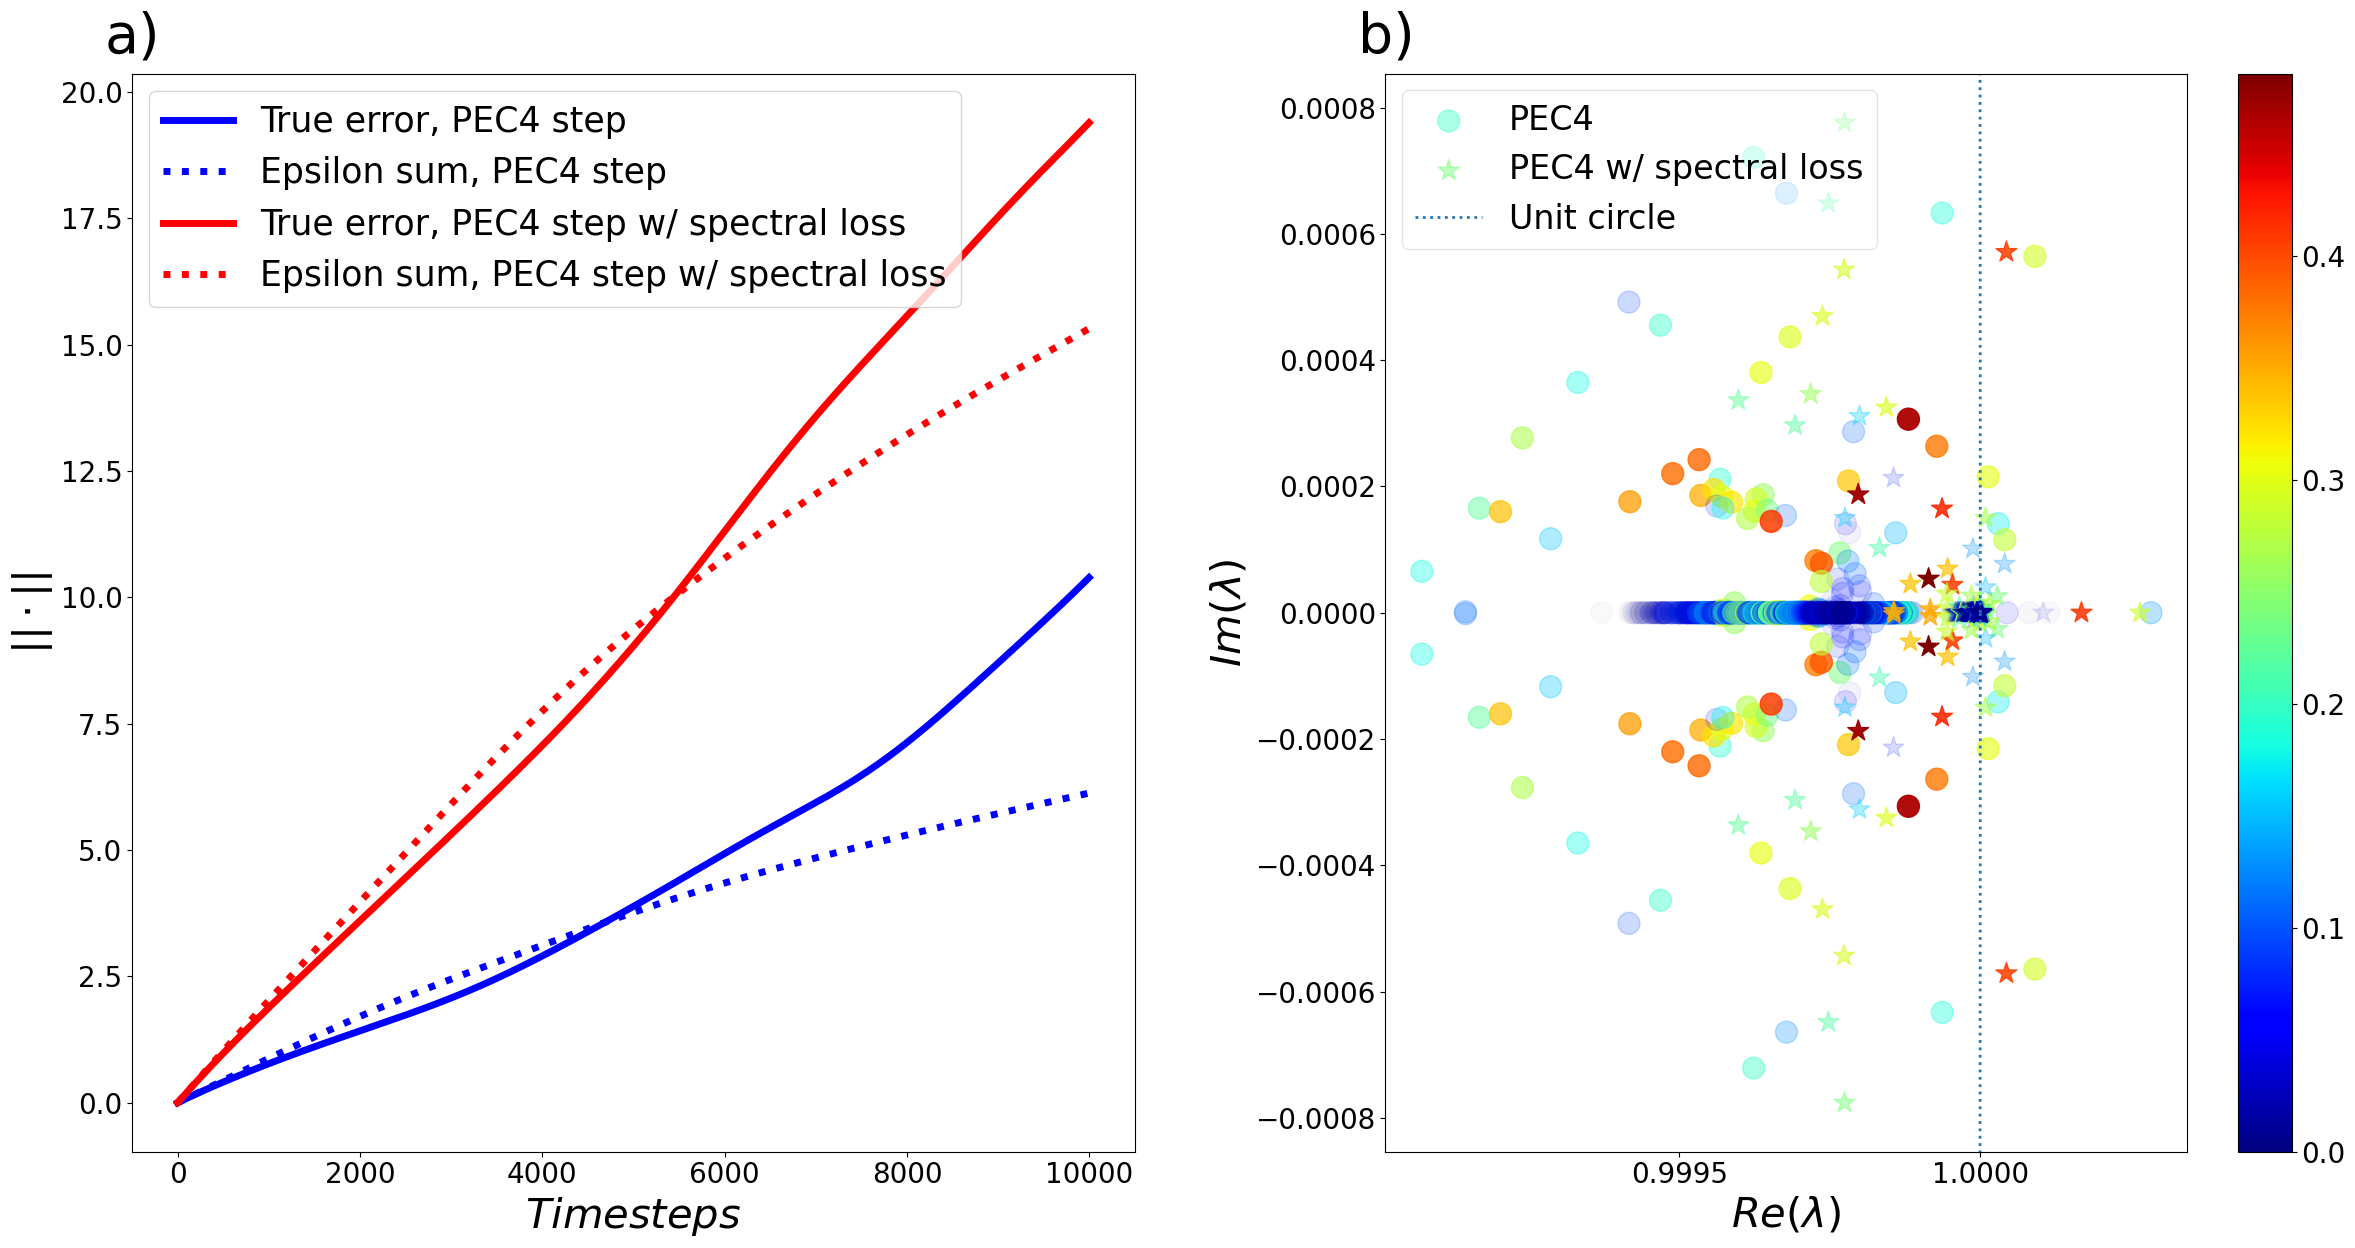

In [101]:
trange = M - 1


residuals =  (lable_lead10[:, 1:trange+1].detach().cpu().numpy() - net_pred_lead10[:, 0:trange])
residuals = residuals / np.linalg.norm(residuals, axis=2)[:, :, None]

residuals_2 = (lable_lead10_jac[:, 1:trange+1].detach().cpu().numpy() - net_pred_lead10_jac[:, 0:trange])
residuals_2 = residuals_2 / np.linalg.norm(residuals_2, axis=2)[:, :, None]

residuals = residuals[0]
residuals_2 = residuals_2[0]


t_num_jacs = 0
t_num_res = 0
net_eigvals, net_eigvecs = np.linalg.eig(ygrad_lead10[0,t_num_jacs])
net_eigvals_2, net_eigvecs_2 = np.linalg.eig(ygrad_lead10_jac[0,t_num_jacs])
# # net_eigvals_3, net_eigvecs_3 = np.linalg.eig(net_3_jacs[t_num])
# # net_eigvals_4, net_eigvecs_4 = np.linalg.eig(net_4_jacs[t_num])
# # net_eigvals_5, net_eigvecs_5 = np.linalg.eig(net_5_jacs[t_num])
# # net_eigvals_6, net_eigvecs_6 = np.linalg.eig(net_6_jacs[t_num])

cmap = (net_eigvecs.T @ residuals[t_num_res])
cmap_2 = (net_eigvecs_2.T @ residuals_2[t_num_res])
# # cmap_3 = (net_eigvecs_3.T @ residuals_3[t_num]).real
# # cmap_4 = (net_eigvecs_4.T @ residuals_4[t_num]).real
# # cmap_5 = (net_eigvecs_5.T @ residuals_5[t_num]).real
# cmap_6 = (net_eigvecs_6.T @ residuals_6[t_num]).real

t_num_res_t = 0
cmap_t = (net_eigvecs.T @ residuals[t_num_res_t])
cmap_2_t = (net_eigvecs_2.T @ residuals_2[t_num_res_t])


fig, axs = plt.subplots(1, 2, figsize=(24, 14))

trange = 10000
# axs[0].plot(np.sqrt(np.mean((net_pred_lead1[:, 0:trange] - lable_lead1[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), color='blue', label='True error, PEC4 step', linewidth=5)
# axs[0].plot(np.sqrt(np.mean(eps_sum_multi_lead1[:,0:trange]**2, axis=2)).mean(0),':', color='blue', label='Epsilon sum, PEC4 step', linewidth=5)

# axs[0].plot(np.sqrt(np.mean((net_pred_lead1_jac[:, 0:trange] - lable_lead1_jac[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), color='red', label='True error, PEC4 step w/ spectral loss', linewidth=5)
# axs[0].plot(np.sqrt(np.mean(eps_sum_multi_lead1_jac[:,0:trange]**2, axis=2)).mean(0),':', color='red', label='Epsilon sum, PEC4 step w/ spectral loss', linewidth=5)


res_norm = np.linalg.norm((net_pred_lead1[:, 0:trange] - lable_lead1[:, 1:trange+1].detach().cpu().numpy()), axis=2)
res_norm_jac = np.linalg.norm((net_pred_lead1_jac[:, 0:trange] - lable_lead1_jac[:, 1:trange+1].detach().cpu().numpy()), axis=2)

eps_norm = np.linalg.norm(eps_sum_multi_lead1[:,0:trange], axis=2)
eps_norm_jac = np.linalg.norm(eps_sum_multi_lead1_jac[:,0:trange], axis=2)

axs[0].plot(res_norm.mean(0), color='blue', label='True error, PEC4 step', linewidth=5)
axs[0].plot(eps_norm.mean(0),':', color='blue', label='Epsilon sum, PEC4 step', linewidth=5)

axs[0].plot(res_norm_jac.mean(0), color='red', label='True error, PEC4 step w/ spectral loss', linewidth=5)
axs[0].plot(eps_norm_jac.mean(0),':', color='red', label='Epsilon sum, PEC4 step w/ spectral loss', linewidth=5)




axs[0].set_xlabel(r'$Timesteps$', fontsize=30)
axs[0].set_ylabel(r'$||\cdot ||$', fontsize=30)
axs[0].legend( prop={'size':25})
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)

norm_colors = colors.Normalize(vmin=0, vmax=max(np.abs(cmap_t.max()), np.abs(cmap_2.max())))

cmap_t_opacities = np.abs(cmap_t)/max(np.abs(cmap_t).max(), np.abs(cmap_2).max())
cmap_2_opacities = np.abs(cmap_2)/max(np.abs(cmap_t).max(), np.abs(cmap_2).max())



scat = axs[1].scatter(net_eigvals.real, net_eigvals.imag, c=np.abs(cmap_t), alpha=cmap_t_opacities, norm=norm_colors, cmap = 'jet', s=250)
scat = axs[1].scatter(net_eigvals_2.real, net_eigvals_2.imag, c=np.abs(cmap_2), alpha=cmap_2_opacities, norm=norm_colors, marker='*', cmap = 'jet', s=250)

xlims = axs[1].get_xlim()
ylims = axs[1].get_ylim()
# xlims = [0.9999, 1.0003]
# ylims = [-0.0004, 0.0004]
t = np.linspace(0,np.pi*2,10000)
axs[1].plot(np.cos(t), np.sin(t), ':', linewidth=2)
axs[1].set_xlim(xlims)
axs[1].set_ylim(ylims)
axs[1].legend(['PEC4','PEC4 w/ spectral loss','Unit circle '], loc='upper left', prop={'size':24}, framealpha=0.5)
cbar = fig.colorbar(scat, ax = axs[1])
cbar.ax.tick_params(labelsize=20) 

axs[1].set_xlabel(r'$Re(\lambda)$', fontsize=30)
axs[1].set_ylabel(r'$Im(\lambda)$', fontsize=30)
axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)
plt.locator_params(axis='x', nbins=3)
# axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,-1))
axs[1].ticklabel_format(useOffset=False, style='plain')


letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)


fig.savefig('Figure_6_v2.png', dpi=300, bbox_inches='tight')

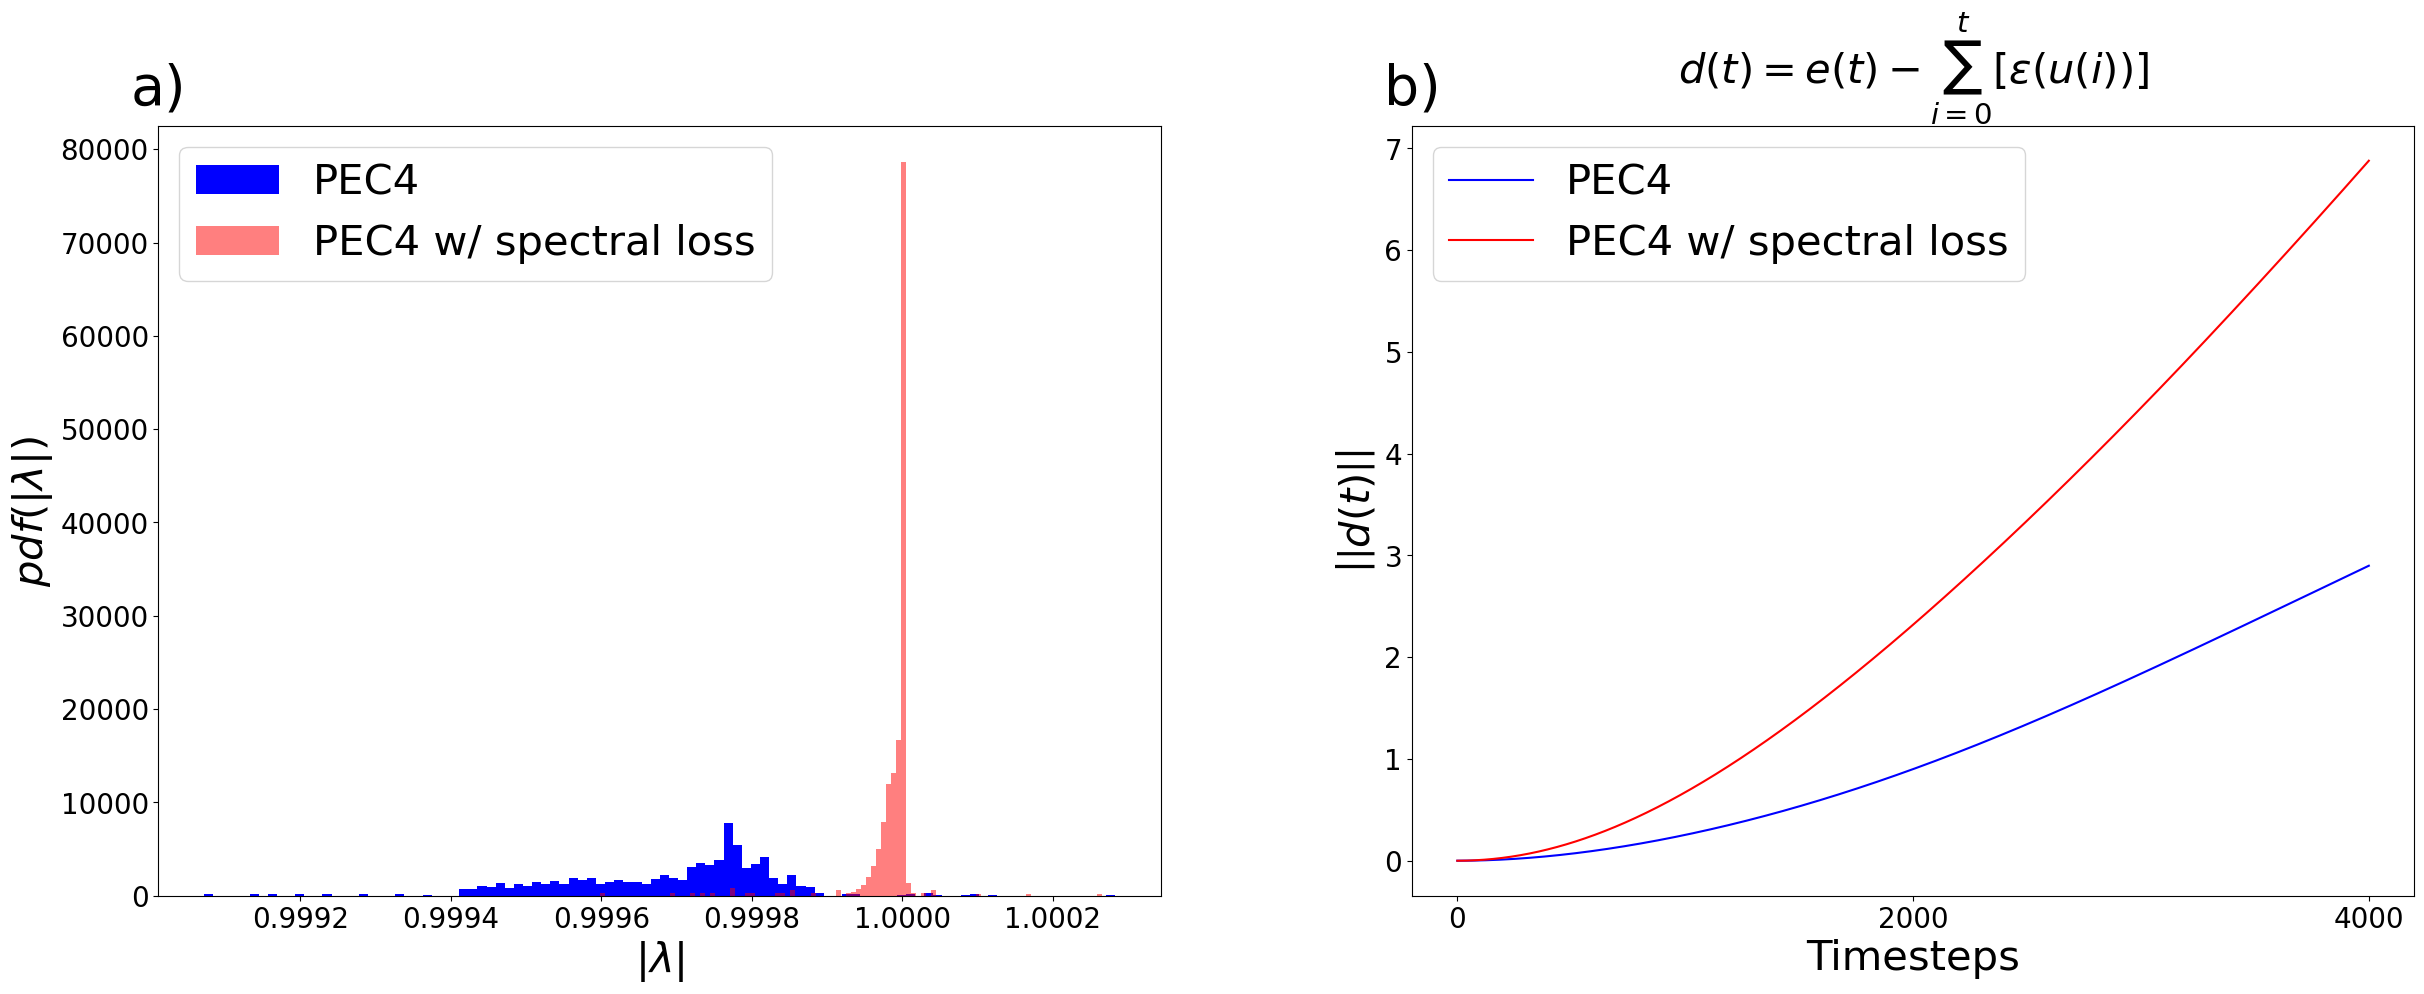

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(24, 10))
axs[0].hist((np.abs(net_eigvals).flatten()), bins=100, density=True, color='blue')

axs[0].hist((np.abs(net_eigvals_2).flatten()), color='red', alpha=0.5, bins=100, density=True)

axs[0].set_ylabel(r'$pdf(|\lambda|)$', fontsize=30)
axs[0].set_xlabel(r'$|\lambda|$', fontsize=30)
axs[0].legend(['PEC4', 'PEC4 w/ spectral loss'], fontsize=30)

# axs[1].hist(torch.imag(e_vals_jacs[:-1,:-1]).flatten().cpu(), color='blue', bins=50, density=True, log=True)
# axs[1].hist(torch.imag(e_vals_no_jacs[:-1,:-1]).flatten().cpu(), bins=50, alpha=0.5, density=True, color='red', log=True)
# axs[1].set_ylabel(r'$pdf(Im(\lambda))$')
# axs[1].set_xlabel(r'$Im(\lambda)$')
# axs[1].legend(['Jacobian augmented loss', 'RMSE loss'], fontsize=30)

# axs[0].set_title('PDF of network jacobian eigenvalue magnitude')
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)

plt.locator_params(axis='x', nbins=3)
# axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,-1))
axs[0].ticklabel_format(useOffset=False, style='plain')



trange = 100000
e_vec = (net_pred_lead1[:, 0:trange] - lable_lead1[:, 1:trange+1].detach().cpu().numpy())
eps_sum = eps_sum_multi_lead1[:,0:trange]
e_vec_jac = (net_pred_lead1_jac[:, 0:trange] - lable_lead1_jac[:, 1:trange+1].detach().cpu().numpy())
eps_sum_jac =  eps_sum_multi_lead1_jac[:,0:trange]

diff_vec_norm = np.linalg.norm(e_vec - eps_sum, axis=2)
diff_vec_norm_jac = np.linalg.norm(e_vec_jac - eps_sum_jac, axis=2)

tstart = 0
tfinal = diff_vec_norm.shape[1]
tfinal = 4000

# axs[1].loglog(np.arange(tstart, tfinal), (diff_vec_norm[:, tstart:tfinal] - diff_vec_norm[:,tstart-1:tfinal-1]).mean(0), color='blue', label='PEC4')

# axs[1].loglog(np.arange(tstart, tfinal), (diff_vec_norm_jac[:, tstart:tfinal] - diff_vec_norm_jac[:,tstart-1:tfinal-1]).mean(0), color='red', label='PEC4 w/ spectral loss')


axs[1].plot(np.arange(tstart, tfinal), (diff_vec_norm[:, tstart:tfinal]).mean(0), color='blue', label='PEC4')

axs[1].plot(np.arange(tstart, tfinal), (diff_vec_norm_jac[:, tstart:tfinal]).mean(0), color='red', label='PEC4 w/ spectral loss')



e_vec_norm = np.linalg.norm(e_vec, axis=2)
e_vec_norm_jac = np.linalg.norm(e_vec_jac, axis=2)


# axs[1].plot((e_vec_norm[:,tstart:]/e_vec_norm[:,tstart-1:-1]).mean(0), color='blue', label='PEC4 ')

# axs[1].plot((e_vec_norm_jac[:,tstart:]/e_vec_norm_jac[:,tstart-1:-1]).mean(0), color='red', label='PEC4 w/ spectral loss')


axs[1].set_xlabel('Timesteps', fontsize=30)
axs[1].set_ylabel(r'$\left|\left|d(t)\right|\right|$', fontsize=30)
axs[1].set_title(r'$d(t) = e(t) - \sum_{i=0}^t\left[\epsilon(u(i))\right]$', fontsize=30)
axs[1].legend( fontsize=30)
# axs[1].xscale('log')

axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)


letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)


fig.savefig('E_val_pdf_PEC4_FNO_method_comparison.png', bbox_inches='tight')

In [25]:
trange = 99999
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Directstep_FNO.npy', 'rb') as f: #change based on eval data location.
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE  = data_dict.item()['RMSE']
net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']
# net_pred_from_truch = data_dict.item()['Pred_from_Truth']
# net_truth_indices = data_dict.item()['Truth_indices']
net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[0])

# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Directstep_MLP.npy', 'rb') as f: #change based on eval data location.
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_tendency_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict_2 = np.load(f, allow_pickle=True)
net_2_pred = data_dict_2.item()['prediction']
net_2_RMSE  = data_dict_2.item()['RMSE']
net_2_FFT_x = data_dict_2.item()['pred_FFT_x']
net_2_jacs = data_dict_2.item()['Jacobians']
net_2_eigvals, net_2_eigvecs = np.linalg.eig(net_2_jacs[0])


In [27]:
residuals =  net_truth[0:100]  - net_pred[0:100] 
residuals = residuals / np.linalg.norm(residuals, axis=1)[:,None]

residuals_2 = net_truth[0:100] - net_2_pred[0:100]
residuals_2 = residuals_2 / np.linalg.norm(residuals_2, axis=1)[:,None]

# residuals_3 = net_truth[0:100] - net_3_pred[0:100]
# residuals_3 = residuals_3 / np.linalg.norm(residuals_3, axis=1)[:,None]

# residuals_4 = net_truth[0:100] - net_4_pred[0:100]
# residuals_4 = residuals_4 / np.linalg.norm(residuals_4, axis=1)[:,None]

# residuals_5 = net_truth[0:100] - net_5_pred[0:100]
# residuals_5 = residuals_5 / np.linalg.norm(residuals_5, axis=1)[:,None]

# residuals_6 = net_truth[0:100] - net_6_pred[0:100]
# residuals_6 = residuals_6 / np.linalg.norm(residuals_6, axis=1)[:,None]

t_num_jacs = 0
t_num_res = 0
net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[t_num_jacs])
net_eigvals_2, net_eigvecs_2 = np.linalg.eig(net_2_jacs[t_num_jacs])
# net_eigvals_3, net_eigvecs_3 = np.linalg.eig(net_3_jacs[t_num])
# net_eigvals_4, net_eigvecs_4 = np.linalg.eig(net_4_jacs[t_num])
# net_eigvals_5, net_eigvecs_5 = np.linalg.eig(net_5_jacs[t_num])
# net_eigvals_6, net_eigvecs_6 = np.linalg.eig(net_6_jacs[t_num])

cmap = (net_eigvecs.T @ residuals[t_num_res])
cmap_2 = (net_eigvecs_2.T @ residuals_2[t_num_res])
# cmap_3 = (net_eigvecs_3.T @ residuals_3[t_num]).real
# cmap_4 = (net_eigvecs_4.T @ residuals_4[t_num]).real
# cmap_5 = (net_eigvecs_5.T @ residuals_5[t_num]).real
# cmap_6 = (net_eigvecs_6.T @ residuals_6[t_num]).real

t_num_res_t = 99
cmap_t = (net_eigvecs.T @ residuals[t_num_res_t])
cmap_2_t = (net_eigvecs_2.T @ residuals_2[t_num_res_t])

# print(((net_eigvals) @ np.abs(cmap)).real, ((net_eigvals_2) @ np.abs(cmap_2)).real, ((net_eigvals_3) @ np.abs(cmap_3)).real)
# np.linalg.norm(net_jacs[t_num] @ residuals[t_num]), np.linalg.norm(net_2_jacs[t_num] @ residuals_2[t_num]), np.linalg.norm(net_3_jacs[t_num] @ residuals_3[t_num])


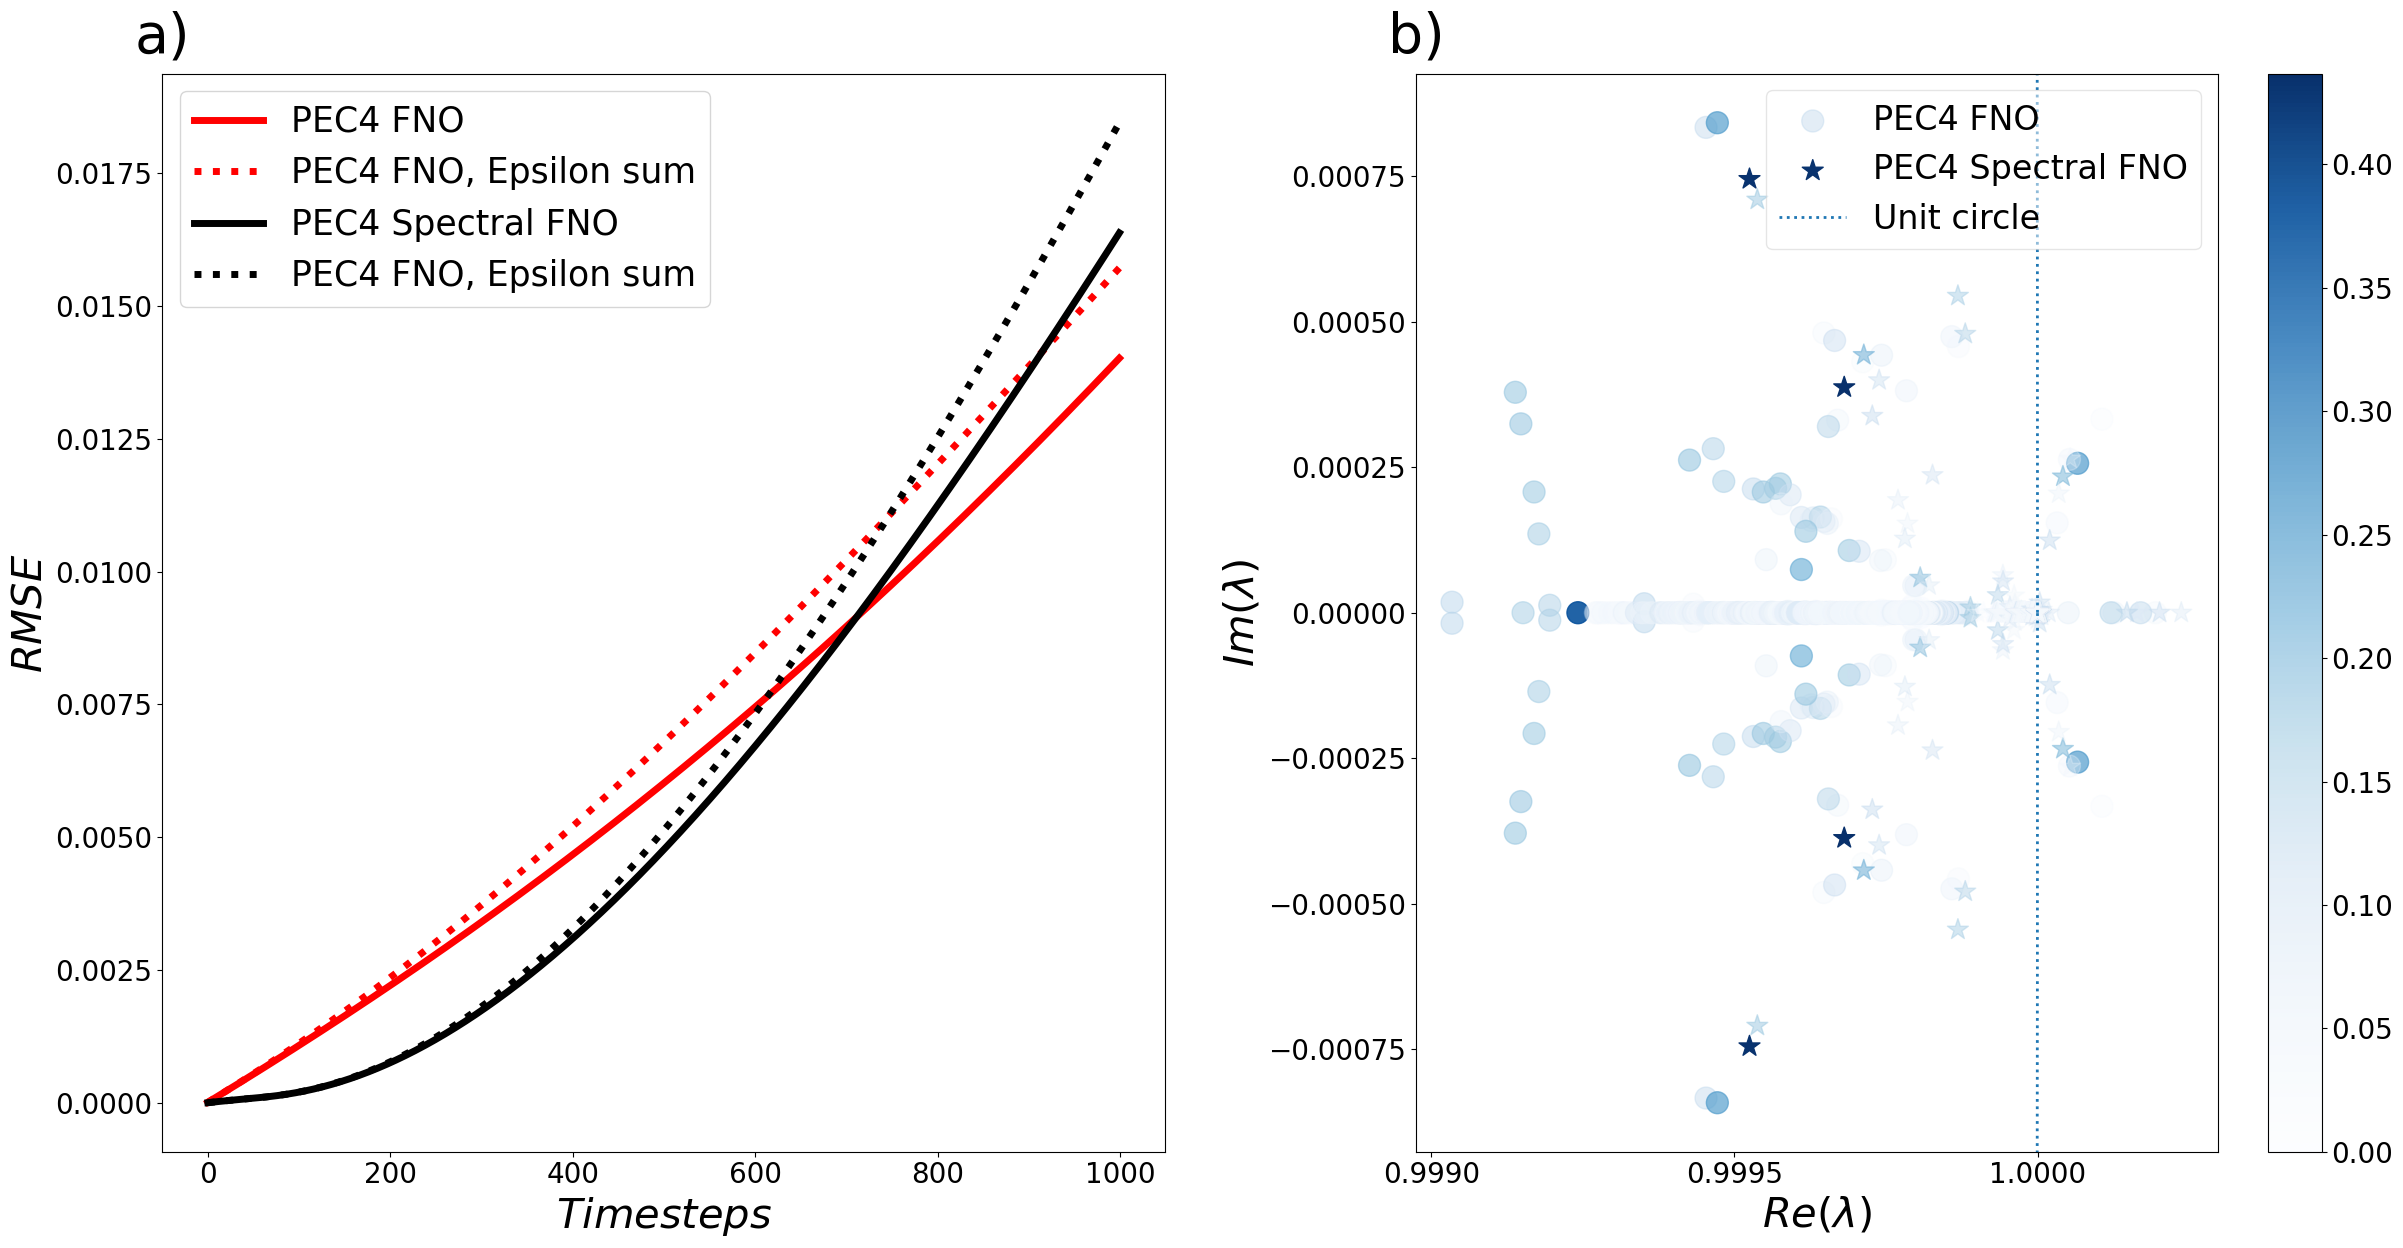

In [80]:
# net_eigvals[np.abs(cmap)<0.1] = 0
# net_eigvals_2[np.abs(cmap_2)<0.1] = 0
# net_eigvals_3[cmap_3<1] = 0
# net_eigvals_4[cmap_3<1] = 0
# net_eigvals_5[cmap_5<1] = 0
# net_eigvals_6[cmap_3<1] = 0
fig, axs = plt.subplots(1, 2, figsize=(24, 14))

trange = 1000
axs[0].plot(net_RMSE[:trange], label='PEC4 FNO', linewidth=5, color='red')
axs[0].plot(np.sqrt(np.mean(eps_sum_no_tendency[0:trange]**2, axis=1)),':', color='red', label='PEC4 FNO, Epsilon sum', lw=5)

            
axs[0].plot(net_2_RMSE[:trange], label='PEC4 Spectral FNO', linewidth=5, color='black')
axs[0].plot(np.sqrt(np.mean(eps_sum_tendency[0:trange]**2, axis=1)),':', color='black', label='PEC4 FNO, Epsilon sum', lw=5)

axs[0].set_xlabel(r'$Timesteps$', fontsize=30)
axs[0].set_ylabel(r'$RMSE$', fontsize=30)
axs[0].legend( prop={'size':25})
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)

norm_colors = colors.Normalize(vmin=0, vmax=max(np.abs(cmap_t.max()), np.abs(cmap_2.max())))

cmap_t_opacities = 0.25 + 0.75*np.abs(cmap_t)/max(np.abs(cmap_t.max()), np.abs(cmap_2.max()))
cmap_2_opacities = 0.25 + 0.75*np.abs(cmap_2)/max(np.abs(cmap_t.max()), np.abs(cmap_2.max()))

cmap_pre = plt.cm.Blues
cmap_a_vals = 0.25 + 0.75*np.linspace(0,1,256)
new_colors = cmap_pre(np.arange(256))
new_colors[:,-1] = cmap_a_vals
cmap_new = colors.ListedColormap(new_colors)

                      
scat = axs[1].scatter(net_eigvals.real, net_eigvals.imag, c=np.abs(cmap_t),  norm=norm_colors, cmap = cmap_new, s=250)
scat = axs[1].scatter(net_eigvals_2.real, net_eigvals_2.imag, c=np.abs(cmap_2),  norm=norm_colors, marker='*', cmap = cmap_new, s=250)

xlims = axs[1].get_xlim()
ylims = axs[1].get_ylim()
# xlims = [0.9999, 1.0003]
# ylims = [-0.0004, 0.0004]
t = np.linspace(0,np.pi*2,10000)
axs[1].plot(np.cos(t), np.sin(t), ':', linewidth=2)
axs[1].set_xlim(xlims)
axs[1].set_ylim(ylims)
axs[1].legend(['PEC4 FNO','PEC4 Spectral FNO','Unit circle '], loc='upper right', prop={'size':24},framealpha=0.5)
cbar = fig.colorbar(scat, ax = axs[1])
cbar.ax.tick_params(labelsize=20) 

axs[1].set_xlabel(r'$Re(\lambda)$', fontsize=30)
axs[1].set_ylabel(r'$Im(\lambda)$', fontsize=30)
axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)
plt.locator_params(axis='x', nbins=3)
# axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,-1))
axs[1].ticklabel_format(useOffset=False, style='plain')


letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)


# fig.savefig('Figure_6_v2.png', dpi=fig.dpi, bbox_inches='tight')